In [1]:
import json
import os

import chromadb
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction, SentenceTransformerEmbeddingFunction
from dotenv import load_dotenv
import tiktoken
import torch

#from src.SentenceTransformerEmbeddingFunction import SentenceTransformerEmbeddingFunction

load_dotenv()

True

## Prepare data embeddings
### Step 1 : Initialize a chromaDB

In [2]:
model_name = "dangvantuan/sentence-camembert-base"
#model_name = "text-embedding-ada-002"
# model_name = "sentence-transformers/all-MiniLM-L6-v2"

match model_name:
    case "text-embedding-ada-002":
        OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
        emb_func = OpenAIEmbeddingFunction(
                        api_key=OPENAI_API_KEY,
                        model_name="text-embedding-ada-002"
                    )

    case other:
        emb_func = SentenceTransformerEmbeddingFunction(
            model_name=model_name,
            device="cuda" if torch.cuda.is_available() else "cpu")


chroma_client = chromadb.PersistentClient(path=os.path.join("./ChromaDB", model_name))

### Step 2 : Add chunked documents to chroma

In [3]:
# create collection using folder's name
SOURCE_FOLDER = "../data\D26\ladrome-2023-12-22-page-chunked-v1"

collection = chroma_client.get_or_create_collection(
    os.path.basename(SOURCE_FOLDER),
    metadata={"hnsw:space": "cosine"},
    embedding_function=emb_func)

In [4]:
# if needed delete a collection
# chroma_client.delete_collection(os.path.basename(SOURCE_FOLDER))

In [5]:
# read the files
file_list = os.listdir(SOURCE_FOLDER)

def read_file(file):
    with open(os.path.join(SOURCE_FOLDER, file), "r") as f:
        return json.load(f)

data = [read_file(f) | {"file": f} for f in file_list]
data[0]

{'id': 'ladrome-page-10511-0.json',
 'token_count': 657,
 'word_count': 361,
 'source_file': 'ladrome-page-10511.json',
 'text': '# Un peu d’histoire\nSituée à mi-chemin entre l’Europe du nord et du sud, à la croisée des vallées du Rhône et de l’Isère, le département de la Drôme a toujours été une terre de passage, de brassage culturel et économique. La rivière Drôme, qui la transperce d’est en ouest, lui a donné son nom. Ses limites administratives ont été fixées en 1790 et en ont fait un département trait d’union entre Dauphiné et Provence. Rivière La Drôme – Crest © Francis Rey Terre d’asile pour les convertis à la Réforme, puis pour les Arméniens survivants du génocide de 1915, la Drôme s’engagea avec bravoure dans la Résistance contre l’occupant nazi. Le massif du Vercors garde la trace du martyre des maquisards et de la population civile perpétré lors des massacres de juillet 1944. La dernière moitié du 20esiècle a vu la Drôme développer ses infrastructures (autoroutes, gare TGV,

In [6]:
# Get an estimate of the total number of token (for cost estimation)
tokeniser = tiktoken.get_encoding("cl100k_base")

n_tokens = sum([len(tokeniser.encode(d["text"])) for d in data])
print("Amount of tokens :", n_tokens)
cost = round(n_tokens/1000*0.0001, 2)
print("Cost using ADAv2 : ", cost, "$")
if cost > 1:
    print("WARNING, BEWARE OF THE COST")

Amount of tokens : 115489
Cost using ADAv2 :  0.01 $


In [7]:
# Build lists to add to chroma
def truncate_text(text, max_tokens_length=8192):
    encoded_text = tokeniser.encode(text)
    return tokeniser.decode(encoded_text[:max_tokens_length])

documents = [truncate_text(d["text"]) for d in data]
metadatas = [{k:v for k,v in d.items() if k in ["chunk_id", "source_file"]} for d in data]
ids = [d["file"] for d in data]

collection.add(
    documents=documents,
    metadatas=metadatas,
    ids=ids,
)

Add of existing embedding ID: ladrome-page-10511-0.json
Add of existing embedding ID: ladrome-page-10516-0.json
Add of existing embedding ID: ladrome-page-10516-1.json
Add of existing embedding ID: ladrome-page-10516-2.json
Add of existing embedding ID: ladrome-page-10516-3.json
Add of existing embedding ID: ladrome-page-10516-4.json
Add of existing embedding ID: ladrome-page-10520-0.json
Add of existing embedding ID: ladrome-page-10520-1.json
Add of existing embedding ID: ladrome-page-10520-2.json
Add of existing embedding ID: ladrome-page-10520-3.json
Add of existing embedding ID: ladrome-page-10520-4.json
Add of existing embedding ID: ladrome-page-10520-5.json
Add of existing embedding ID: ladrome-page-10520-6.json
Add of existing embedding ID: ladrome-page-10522-0.json
Add of existing embedding ID: ladrome-page-10522-1.json
Add of existing embedding ID: ladrome-page-10522-10.json
Add of existing embedding ID: ladrome-page-10522-11.json
Add of existing embedding ID: ladrome-page-105

## Try out the DB

In [8]:
# Choose a collection name
#collection_name = "ladrome-2023-12-22-page-chunked-v1"
collection_name = "ladrome-2023-12-22-md"
# Choose a query
query = "Adresse de la MDA de Valence ?"
# choose the number of results
n_results = 10
# choose whether or not results are printed
print_results = True

collection = chroma_client.get_or_create_collection(
    collection_name,
    metadata={"hnsw:space": "cosine"},
    embedding_function=emb_func)

result = collection.query(
    query_texts=query,
    n_results=n_results,
)

if print_results:
    for rd, id in zip(result["documents"][0], result["ids"][0]):
        print(f"---------{id}---------")
        print(rd)

---------ladrome-page-10936.json---------
La lutte contre la tuberculose

Vous pensez avoir été en contact avec une personne atteinte de la tuberculose ?

En cas de suspicion de symptômes, consultez le Centre de Lutte Anti-Tuberculeux (CLAT) de la Drôme.

13 avenue Maurice Faure

BP 81132 – 26 011 Valence Cedex 9

Tel 04 75 79 70 71
---------ladrome-page-11020.json---------
Les stations de la Drôme


---------ladrome-page-10565.json---------
Un département, des territoires

Située au cœur du grand Sud-Est de la France, la Drôme est l’un des 12 départements de la Région Auvergne Rhône-Alpes.

*   **Préfecture** : Valence
*   **Sous-préfectures** : Die, Nyons
*   **Villes de plus de 10 000 habitants** : Valence, Montélimar, Romans, Bourg-lès-Valence, Pierrelatte, Bourg de Péage
*   **A savoir** : la Drôme est depuis toujours un département pionnier en agriculture bio, et le 1er département agricole d’Auvergne Rhône-Alpes
*   **Particularité** : comme son nom l’indique, l’enclave des Pape

## Test with labeled datasets
### Step 1 : compare with handmade data

In [9]:
import pandas as pd

In [10]:
dataset = pd.read_excel("../data/D26/D26_dataset_handmade.xlsx")
dataset["relevant_chunk_ids"] = dataset["relevant_chunk_ids"].str.split()
dataset.dropna(inplace=True, subset=["relevant_chunk_ids"])
dataset.head()

,queries,queries as keywords,chunk_version,relevant_chunk_ids,useful_links_available,long answer,keywords,Unnamed: 7
0,Combien de productions ont déjà bénéficié du f...,bénéficiare fond soutien œuvres animées,1.0,[ladrome-page-573222-1.json],NaN,15 à 20 projet bénéficient d'une subvention ch...,83,NaN
1,Je voudrais bénéficier de l'accueil familial. ...,contact acceuil familial,1.0,[ladrome-page-13929-0.json],NaN,Vous pouvez contacter Drôme Solidarités\n04 75...,Drôme Solidarités 04 75 79 70 09 dromeseniorso...,NaN
2,Quels sont les horaires du musée départemental...,horaire musée de la résistance,1.0,[ladrome-page-10958-3.json],NaN,Les horaires d'ouverture varient d'un mois à l...,"avril :du mardi au dimanche, de 10h à 12h et d...",NaN
3,Quels sont les résultats de conformité du site...,résultats conformité acessibilité site,1.0,[ladrome-page-479533-2.json],NaN,L’audit de conformité au RGAA 4.1 réalisé par ...,0.8958,NaN
4,Qu'est ce que la cartoucherie ?,explication cartoucherie,1.0,[ladrome-page-10516-3.json],NaN,Sous l’impulsion de Jacques-Rémy Girerd (studi...,pôle d’excellence régional de l’image animée,NaN


In [11]:
# Choose a collection name
collection_name = "ladrome-2023-12-22-page-chunked-v1"

# Query the DB with all queries
queries = dataset["queries"].tolist()
collection = chroma_client.get_or_create_collection(
    collection_name,
    metadata={"hnsw:space": "cosine"},
    embedding_function=emb_func)
n_results = collection.count() # get the results on the entire DB

print(f"The collection has {collection.count()} documents")

result = collection.query(
    query_texts=queries,
    n_results=n_results,
)

The collection has 361 documents


In [12]:
result_df = pd.DataFrame.from_dict(result)
result_df.drop(["embeddings", "uris", "data"], inplace=True, axis=1)
result_df["query"] = queries
result_df["label"] = dataset["relevant_chunk_ids"].tolist()
result_df.head(3)

,ids,distances,metadatas,documents,query,label
0,"[ladrome-page-573222-1.json, ladrome-page-1096...","[0.575617840095566, 0.6614375114440918, 0.7035...","[{'source_file': 'ladrome-page-573222.json'}, ...",[# Le cinéma d’animation dans la Drôme\n### Le...,Combien de productions ont déjà bénéficié du f...,[ladrome-page-573222-1.json]
1,"[ladrome-page-10759-0.json, ladrome-page-10765...","[0.49739736318588257, 0.51413893699646, 0.5231...","[{'source_file': 'ladrome-page-10759.json'}, {...","[# L’adoption\nAdopter un enfant, c’est répond...",Je voudrais bénéficier de l'accueil familial. ...,[ladrome-page-13929-0.json]
2,"[ladrome-page-10958-0.json, ladrome-page-10958...","[0.48037004470825195, 0.5899790525436401, 0.59...","[{'source_file': 'ladrome-page-10958.json'}, {...",[# Le musée départemental de la Résistance du ...,Quels sont les horaires du musée départemental...,[ladrome-page-10958-3.json]


In [13]:
# Get the position of the labeled document in the results using metadatas
# best if rank closer to 0
def get_label_position(row):
    # get the source files, which are ordered by distance
    return row["ids"].index(row["label"][0])


result_df["label_rank"] = result_df.apply(get_label_position, axis=1)
result_df = result_df.sort_values(by="label_rank").reset_index()
# show the result
result_df[["query", "label_rank", "label"]].head(100)

,query,label_rank,label
0,Combien de productions ont déjà bénéficié du f...,0,[ladrome-page-573222-1.json]
1,Où puis-je trouver les logo du département ?,0,[ladrome-page-62538-0.json]
2,Je voudrais me mettre au basket. Où puis-je tr...,0,[ladrome-page-11012-0.json]
3,Quelles sont les règles du buget participatif ?,0,[ladrome-page-547395-6.json]
4,Par quelles villes va passer la flamme olympiq...,0,[ladrome-page-567239-2.json]
...,...,...,...
74,Ou en est mon dossier AAH ?,98,[ladrome-page-10791-0.json]
75,Quels sont les tiers lieux en drome ?,189,[ladrome-page-504975-0.json]
76,C'est quoi le CDJ ? A quoi ça sert ?,194,[ladrome-page-11080-0.json]
77,J'aimerai obtenir des information sur la situa...,225,[ladrome-page-582085-4.json]


In [14]:
# analyze result of the specific query id
query_id = 49 # the index of the dataframe above
topk = 10

record = result_df.iloc[query_id]
print(record["query"])
for i, (id, r) in enumerate(zip(record["ids"][:topk], record["documents"][:topk])):
    print(f"Chunk n°{i}--------------{id}------------------")
    print(r)

Comment puis-je obtenir la carte top dép'art ?
Chunk n°0--------------ladrome-page-17218-5.json------------------
# La carte Top Dép’Art
## Pour commander la carte Top Dép’Artcarte-topdepart.ladrome.fr (pour plus d'informations : https://carte-topdepart.ladrome.fr/Accueil/)
### Où utiliser ma carte top dép’art ?
Retrouvez sur la carte interactive (pour plus d'informations : https://carte-topdepart.ladrome.fr/Beneficiaires/Views/RechercheLocalisation_PartenaireV2.aspx) la liste des partenaires qui acceptent le paiement avec la carte Top Dép’art.

Chunk n°1--------------ladrome-page-17218-0.json------------------
# La carte Top Dép’Art
Acheter un livre, payer sa licence de sport, visiter une exposition ou prendre des cours de théâtre, le Département délivre chaque année la carte « Top Dép’art », à tous les collégiens de la Drôme. ---

Chunk n°2--------------ladrome-page-17218-3.json------------------
# La carte Top Dép’Art
## Pour commander la carte Top Dép’Artcarte-topdepart.ladrome.fr 

In [16]:
# Store df in new variable for comparison later
result_handmade_dataset = result_df.copy()

### Step 2 : Resuts on data generated with GPT-3.5-turbo

In [30]:
dataset = pd.read_json("../data/D26/generated_data_gpt-3-5-turbo.json")
dataset.rename({"query": "queries", "relevant_ids": "relevant_chunk_ids"}, axis=1, inplace=True)
dataset["relevant_chunk_ids"] = dataset["relevant_chunk_ids"].str.split()
dataset.dropna(inplace=True, subset=["relevant_chunk_ids"])

dataset.head()

,queries,long_answer,short_answer,relevant_chunk_ids
0,Quelle est l'enveloppe du Fonds de Soutien aux...,L'enveloppe du Fonds de Soutien aux Œuvres Ani...,[enveloppe],[ladrome-page-573222-1.json]
1,Combien d'accueillants familiaux sont agréés d...,88 accueillants familiaux sont agréés dans la ...,[88],[ladrome-page-13929-0.json]
2,Quels sont les horaires d'ouverture en septembre?,"En septembre, le musée départemental de la Rés...",[septembre],[ladrome-page-10958-3.json]
3,Quel est le pourcentage de critères RGAA respe...,Le pourcentage de critères RGAA respectés est ...,"[89,58%]",[ladrome-page-479533-2.json]
4,Quelles écoles sont présentes à la Cartoucherie?,Les écoles présentes à la Cartoucherie sont l'...,[écoles],[ladrome-page-10516-3.json]


In [31]:
# Choose a collection name
collection_name = "ladrome-2023-12-22-page-chunked-v1"

# Query the DB with all queries
queries = dataset["queries"].tolist()
collection = chroma_client.get_or_create_collection(
    collection_name,
    metadata={"hnsw:space": "cosine"},
    embedding_function=emb_func)
n_results = collection.count() # get the results on the entire DB

print(f"The collection has {collection.count()} documents")

result = collection.query(
    query_texts=queries,
    n_results=n_results,
)

The collection has 361 documents


In [32]:
result_df = pd.DataFrame.from_dict(result)
result_df.drop(["embeddings", "uris", "data"], inplace=True, axis=1)
result_df["query"] = queries
result_df["label"] = dataset["relevant_chunk_ids"].tolist()
result_df.head(3)

,ids,distances,metadatas,documents,query,label
0,"[ladrome-page-573222-1.json, ladrome-page-5589...","[0.5545825404861384, 0.6579045653343201, 0.681...","[{'source_file': 'ladrome-page-573222.json'}, ...",[# Le cinéma d’animation dans la Drôme\n### Le...,Quelle est l'enveloppe du Fonds de Soutien aux...,[ladrome-page-573222-1.json]
1,"[ladrome-page-13929-0.json, ladrome-page-10909...","[0.42055076360702515, 0.4218701720237732, 0.46...","[{'source_file': 'ladrome-page-13929.json'}, {...",[# L’accueil familial pour les personnes âgées...,Combien d'accueillants familiaux sont agréés d...,[ladrome-page-13929-0.json]
2,"[ladrome-page-547344-3.json, ladrome-page-5473...","[0.7604168653488159, 0.8158667087554932, 0.823...","[{'source_file': 'ladrome-page-547344.json'}, ...",[# FAQ – futur collège Mercurol-Veaunes\n### E...,Quels sont les horaires d'ouverture en septembre?,[ladrome-page-10958-3.json]


In [33]:
# Get the position of the labeled document in the results using metadatas
# best if rank closer to 0
def get_label_position(row):
    # get the source files, which are ordered by distance
    return row["ids"].index(row["label"][0])


result_df["label_rank"] = result_df.apply(get_label_position, axis=1)
result_df = result_df.sort_values(by="label_rank").reset_index()
# show the result
result_df[["query", "label_rank", "label"]].head(100)

,query,label_rank,label
0,Quelle est l'enveloppe du Fonds de Soutien aux...,0,[ladrome-page-573222-1.json]
1,Combien de sites drômois sont classés ENS débu...,0,[ladrome-page-10989-0.json]
2,Quelles sont les étapes du passage de la flamm...,0,[ladrome-page-567239-2.json]
3,Quelles sont les activités de montagne pratica...,0,[ladrome-page-61497-1.json]
4,Quelle est la superficie de la forêt de Saoû?,0,[ladrome-page-61260-0.json]
...,...,...,...
74,Quel est le montant de la nouvelle stratégie 2...,17,[ladrome-page-558957-0.json]
75,Quels sont les horaires d'ouverture de la Mais...,33,[ladrome-page-10793-1.json]
76,Quels sont les horaires d'ouverture de la Mais...,39,[ladrome-page-10793-1.json]
77,Quelles sont les coordonnées pour contacter le...,39,[ladrome-page-581681-9.json]


In [34]:
# analyze result of the specific query id
query_id = 49 # the index of the dataframe above
topk = 10

record = result_df.iloc[query_id]
print(record["query"])
for i, (id, r) in enumerate(zip(record["ids"][:topk], record["documents"][:topk])):
    print(f"Chunk n°{i}--------------{id}------------------")
    print(r)

Quel est le coût mensuel de l'abonnement à Drôme Téléassistance?
Chunk n°0--------------ladrome-page-480456-5.json------------------
# Conditions générales d’utilisation de l’application mobile La Drôme
## Article 5. CONDITIONS FINANCIERES
L’Application est proposée gratuitement aux Utilisateurs hors coûts d’abonnement auprès de l’opérateur de téléphonie mobile, hors coûts de connexion et d’accès au réseau Internet et hors surcoût éventuel facturé pour le chargement des données.

Chunk n°1--------------ladrome-page-10870-0.json------------------
# Téléassistance
Avec Drôme Téléassistance, quel que soit votre lieu d’habitation dans la Drôme et pour un abonnement mensuel de 7,44€ (ou 10,44€ avec le détecteur de chutes) vous pouvez rester à domicile en toute sécurité. Grâce à un pendentif ou un bracelet, par simple pression vous activez une téléalarme qui permet de signaler un problème (malaise, chute…). L’installation et la mise en service sont gratuites. Si vous êtes bénéficiaire de l’A

In [35]:
# Store df in new variable for comparison later
result_gpt_dataset = result_df.copy()

### Step 3 : Resuts on data generated with mistral-small

In [37]:
dataset = pd.read_json("../data/D26/generated_data_mistral-small.json")
dataset.rename({"query": "queries", "relevant_ids": "relevant_chunk_ids"}, axis=1, inplace=True)
dataset["relevant_chunk_ids"] = dataset["relevant_chunk_ids"].str.split()
dataset.dropna(inplace=True, subset=["relevant_chunk_ids"])

dataset.head()

,queries,long_answer,short_answer,relevant_chunk_ids
0,Quel organisme a fourni 100 000€ au Fonds de S...,Le CNC (centre national du cinéma et de l'imag...,"[Fonds de Soutien aux Œuvres Animées, 2023, Ce...",[ladrome-page-573222-1.json]
1,Les accueillants familiaux peuvent-ils être de...,"Oui, dans la Drôme, les accueillants familiaux...","[accueillants familiaux, personnes âgées, Dépa...",[ladrome-page-13929-0.json]
2,"Le musée est-il ouvert en février, à part la p...","Non, le musée départemental de la Résistance d...",None,[ladrome-page-10958-3.json]
3,Quel est le pourcentage de critères RGAA respe...,"Selon l'audit réalisé par la société Temesis, ...","[89.58%, des critères RGAA sont respectés, Nom...",[ladrome-page-479533-2.json]
4,Quelle école de cinéma d'animation reconnue pa...,La Poudrière,"[La Poudrière, école reconnue par le Ministère...",[ladrome-page-10516-3.json]


In [38]:
# Choose a collection name
collection_name = "ladrome-2023-12-22-page-chunked-v1"

# Query the DB with all queries
queries = dataset["queries"].tolist()
collection = chroma_client.get_or_create_collection(
    collection_name,
    metadata={"hnsw:space": "cosine"},
    embedding_function=emb_func)
n_results = collection.count() # get the results on the entire DB

print(f"The collection has {collection.count()} documents")

result = collection.query(
    query_texts=queries,
    n_results=n_results,
)

The collection has 361 documents


In [39]:
result_df = pd.DataFrame.from_dict(result)
result_df.drop(["embeddings", "uris", "data"], inplace=True, axis=1)
result_df["query"] = queries
result_df["label"] = dataset["relevant_chunk_ids"].tolist()
result_df.head(3)

,ids,distances,metadatas,documents,query,label
0,"[ladrome-page-547395-3.json, ladrome-page-5732...","[0.5154118537902832, 0.5764145076311558, 0.617...","[{'source_file': 'ladrome-page-547395.json'}, ...",[# Budget Participatif\n### Quel type de proje...,Quel organisme a fourni 100 000€ au Fonds de S...,[ladrome-page-573222-1.json]
1,"[ladrome-page-13929-0.json, ladrome-page-10909...","[0.3998752236366272, 0.4232432246208191, 0.592...","[{'source_file': 'ladrome-page-13929.json'}, {...",[# L’accueil familial pour les personnes âgées...,Les accueillants familiaux peuvent-ils être de...,[ladrome-page-13929-0.json]
2,"[ladrome-page-10958-3.json, ladrome-page-10958...","[0.7064592838287354, 0.7271482944488525, 0.776...","[{'source_file': 'ladrome-page-10958.json'}, {...",[# Le musée départemental de la Résistance du ...,"Le musée est-il ouvert en février, à part la p...",[ladrome-page-10958-3.json]


In [40]:
# Get the position of the labeled document in the results using metadatas
# best if rank closer to 0
def get_label_position(row):
    # get the source files, which are ordered by distance
    return row["ids"].index(row["label"][0])


result_df["label_rank"] = result_df.apply(get_label_position, axis=1)
result_df = result_df.sort_values(by="label_rank").reset_index()
# show the result
result_df[["query", "label_rank", "label"]].head(100)

,query,label_rank,label
0,Le site permet-il de connaître l'état d'ouvert...,0,[ladrome-page-11020-0.json]
1,Les élèves ayant débuté une langue vivante ont...,0,[ladrome-page-547344-3.json]
2,Quel est le lien pour télécharger la carte des...,0,[ladrome-page-10537-0.json]
3,Quel numéro appeler en cas de maltraitance env...,0,[ladrome-page-10799-0.json]
4,Jusqu'à quel montant s'élèvent les bourses dép...,0,[ladrome-page-10738-0.json]
...,...,...,...
74,Quand le rapport de la CLIGEET sur le projet A...,47,[ladrome-page-13832-0.json]
75,Comment contacter MDA - Drôme Solidarités ?,47,[ladrome-page-10876-1.json]
76,Comment contacter le Département de la Drôme p...,90,[ladrome-page-581681-9.json]
77,Quelle association contacter pour des conseils...,242,[ladrome-page-10922-0.json]


In [41]:
# analyze result of the specific query id
query_id = 49 # the index of the dataframe above
topk = 10

record = result_df.iloc[query_id]
print(record["query"])
for i, (id, r) in enumerate(zip(record["ids"][:topk], record["documents"][:topk])):
    print(f"Chunk n°{i}--------------{id}------------------")
    print(r)

Comment obtenir un logement social ?
Chunk n°0--------------ladrome-page-10920-2.json------------------
# Les aides aux locataires
### Le droit au logement opposable
Le droit au logement opposable concerne les personnes dont les démarches en vue de louer un logement ou de se maintenir dans le logement qu’elles louaient, n’ont pas abouti. Dépourvu de logement, hébergé par une autre personne, menacé d’expulsion, logé de manière temporaire ou dans un foyer-logement, logé dans un squat… Vous pouvez faire une action via le formulaire du droit au logement opposable. (pour plus d'informations : https://www.service-public.fr/particuliers/vosdroits/R19319)

Chunk n°1--------------ladrome-page-10920-3.json------------------
# Les aides aux locataires
### Les logements sociaux
Les logements sociaux sont attribués aux personnes et familles dont les ressources n’excèdent pas un certain niveau. Pour obtenir un logement social, vous devez dans un premier temps obtenir un numéro départemental d’enregi

In [42]:
# Store df in new variable for comparison later
result_mistral_dataset = result_df.copy()

### Step 4 : Compare !
#### Position of the relevant document in the retrieved documents

In [45]:
collection_size = len(result_handmade_dataset.iloc[0]["ids"])
print(f"Collection size : {collection_size}")
result_handmade_dataset.head(2)

Collection size : 361


,index,ids,distances,metadatas,documents,query,label,label_rank
0,0,"[ladrome-page-573222-1.json, ladrome-page-1096...","[0.575617840095566, 0.6614375114440918, 0.7035...","[{'source_file': 'ladrome-page-573222.json'}, ...",[# Le cinéma d’animation dans la Drôme\n### Le...,Combien de productions ont déjà bénéficié du f...,[ladrome-page-573222-1.json],0
1,29,"[ladrome-page-62538-0.json, ladrome-page-10728...","[0.6856098959777752, 0.6959853768348694, 0.726...","[{'source_file': 'ladrome-page-62538.json'}, {...",[# Charte graphique\nLe logo du Département de...,Où puis-je trouver les logo du département ?,[ladrome-page-62538-0.json],0


In [46]:
def get_label_rank_percentage(result_df, collection_size):
    """Get the cumulative percentage of the rank of the relevant document

    Args:
        result_df (pd.DataFrame): the results of the retriever
        collection_size (int): the size of the collection of documents
    """
    chunk_rank_counts = result_df["label_rank"].value_counts().sort_index()
    missing_indexes = [i for i in range(collection_size) if i not in chunk_rank_counts.index]
    chunk_rank_counts = pd.concat(
        [chunk_rank_counts,
        pd.DataFrame([0 for _ in range(len(missing_indexes))],
        index=missing_indexes)]).sort_index()
    chunk_rank_percent = chunk_rank_counts.cumsum().div(len(result_df)).round(3)

    return chunk_rank_percent

In [47]:
handmade_chunk_rank_percent = get_label_rank_percentage(result_handmade_dataset, collection_size).rename(columns={0: "handmade dataset"})
gpt_chunk_rank_percent = get_label_rank_percentage(result_gpt_dataset, collection_size).rename(columns={0: "gpt-3.5 dataset"})
mistral_chunk_rank_percent = get_label_rank_percentage(result_mistral_dataset, collection_size).rename(columns={0: "mistral-small dataset"})

<Axes: title={'center': 'Recall vs document retrieval rank'}>

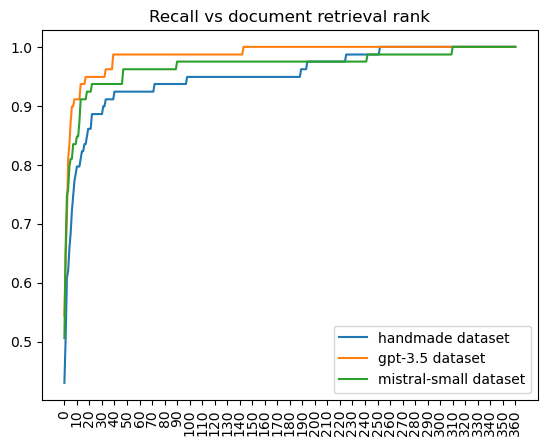

In [48]:
# Plot the cumulative percentage of retrieval position
df_to_plot = pd.concat([handmade_chunk_rank_percent, gpt_chunk_rank_percent, mistral_chunk_rank_percent], axis=1)
df_to_plot.plot(xticks=[i for i in df_to_plot.index if i % 10 == 0], rot=90, title="Recall vs document retrieval rank")

As we can see, the new chunking method performs better : the position at which the relevant document is retrieved is closer to 0, despite having a greater amount of documents in the collection !
WARNING : As the queries were built using the new chunks, there might be bias to keep in mind !

<Axes: title={'center': 'Recall vs document retrieval rank'}>

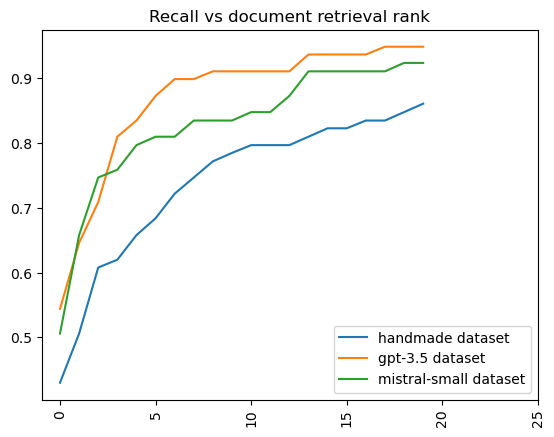

In [49]:
# Zoom on the begining of the curve
df_to_plot[:20].plot(xticks=[i for i in df_to_plot.index[:30] if i % 5 == 0], rot=90, title="Recall vs document retrieval rank")

##### Conclusion
It seems that the generating queries from the chunks using AI presents a positive bias leading to an increase in performance.
- Generated queries lead to improved retrieval rates
- We could try to improve the generation by modifying the prompt